# Модуль 3: Сверточные нейронные сети (CNN)

## Теория

### Определения

Сверточные нейронные сети (CNN) являются одним из самых эффективных инструментов для анализа визуальных данных. Основные элементы, которые используются в сверточных нейронных сетях:  
1. Сверточные слои (nn.Conv2d): Эти слои позволяют модели извлекать локальные особенности из изображений, используя фильтры (ядра). При выполнении свертки фильтры проходят по изображению, генерируя карты признаков.
2. Слои подвыборки (nn.MaxPool2d): Эти слои уменьшают размер карт признаков, что помогает сократить вычислительные затраты и позволяет модели быть более устойчивой к искажениям и смещениям.
3. Нелинейные функции активации: Например, ReLU (nn.ReLU()), которые добавляют нелинейность в модель, помогая моделям изучать сложные зависимости.
4. Полносвязные слои (nn.Linear): Эти слои используются в конце сети, чтобы выполнить финальную классификацию на основе извлеченных признаков.
5. Регуляризация: Dropout и другие техники помогают уменьшить переобучение.

### Как работают CNN?

- **Свертка**: Входные изображения проходят через несколько сверточных слоев, где каждый слой обучает свою группу фильтров для извлечения специфических признаков.
- **Пулинг**: После сверточных операций применяется слой пулинга, который уменьшает размерность карты признаков, сохраняя наиболее важные данные.
- **Складная структура**: Сложение нескольких слоев свертки и пулинга помогает сети обучаться на уровнях абстракции, от низкоуровневых (например, края, текстуры) до высокоуровневых (например, формы, объекты).

### Расчет размерности данных после сверточного слоя

Для сверточного слоя, выходной размер (H_out и W_out) вычисляется по формуле:  
  
$H_{out} = (\frac{H_{in} + 2P - K}{S} + 1)$  
  
$W_{out} = (\frac{W_{in} + 2P - K}{S} + 1)$  
  
где:
$H_{in}, W_{in}$ - высота и ширина входного изображения, $P$ - отступ (padding), $K$ - размер ядра (kernel_size), $S$ - шаг (stride).

### Расчет размерности данных после Max Pooling:

Для сверточного слоя, выходной размер (H_out и W_out) вычисляется по формуле:  
  
$H_{out} = (\frac{H_{in} + 2P - K}{S} + 1)$  
  
$W_{out} = (\frac{W_{in} + 2P - K}{S} + 1)$  
  
где:
$H_{in}, W_{in}$ - высота и ширина входного изображения, $P$ - отступ (padding), $K$ - размер ядра (kernel_size), $S$ - шаг (stride).

## Задачи

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# Указание в качестве девайса GPU если доступна
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Функции

In [24]:
def train_model(
        model: nn.Module,
        num_epochs: int,
        optimizer: torch.optim,
        criterion: torch.nn,
        train_dataloader: DataLoader
    ):
    """
    Функция для обучения модели.
    
    Args:
        model (nn.Module): модель для обучения
        num_epochs (int): кол-во итераций обучения
        optimizer (torch.optim): оптимизатор
        criterion (torch.nn): функция потерь
        train_dataloader (torch.utils.data.DataLoader): загрузчик данных

    Output:
        loss_list (list): список значений функции потерь за каждый батч
        acc_list (list): список точностей за каждый батч

    """
    loss_list = []
    acc_list = []

    # Кол-во обучающих премеров
    train_amount = len(train_dataloader)

    # Загрузка модели на GPU
    model.train().to(device)
    # Обучение
    for epoch in range(num_epochs):
        total_loss = 0
        total_acc = 0
        
        for data, targets in train_dataloader:
            # Обнуление градиентов
            optimizer.zero_grad()

            # Перевод всех данных на GPU
            data, targets = data.to(device), targets.to(device)

            # Предсказания модели
            outputs = model(data)

            # Расчет функции потерь
            loss = criterion(outputs, targets)

            # Прибавление функции потерь к общей потере за эпоху
            total_loss += loss.item()

            # Вычисление градиентов
            loss.backward()

            # Отпимизация весов на основе расчитанных градиентов
            optimizer.step()

            # Расчет точности (accuracy)
            total = targets.shape[0]
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == targets).sum().item()
            total_acc += correct / total
        
        # Расчет средней точности за эпоху
        avg_loss = total_loss / train_amount
        loss_list.append(avg_loss)

        # Расчет средней точности за эпоху
        avg_accuracy = total_acc / train_amount
        acc_list.append(avg_accuracy)

        # Вывод информации об эпохе обучения модели
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {avg_loss:.2f}, Accuracy: {avg_accuracy:.2f}')

    return loss_list, acc_list


In [25]:
def eval_model(
    model: nn.Module,
    test_dataloader: DataLoader  
):
    """
    Функция для оценки обученной модели.

    Args:
        model (nn.Module): обученная модель
        test_dataloader (DataLoader): даталодер для тестовых данных

    Output:
        None
    """

    # Оценка обученной модели
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, targets in test_dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.shape[0]
            correct += (predicted == targets).sum().item()

        print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_dataloader), (correct / total) * 100))

### Создать простую сверточную нейронную сеть для CIFAR-10:
Реализовать CNN с использованием слоев nn.Conv2d, nn.MaxPool2d и nn.Linear для классификации изображений CIFAR-10.

In [3]:
# Загрузка датасета (обучающие + тестовые данные)
train_dataset = datasets.CIFAR10(
    root="../data",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = datasets.CIFAR10(
    root="../data",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Определение Dataloaders для удобства обучения модели нейросети на данных батчами
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

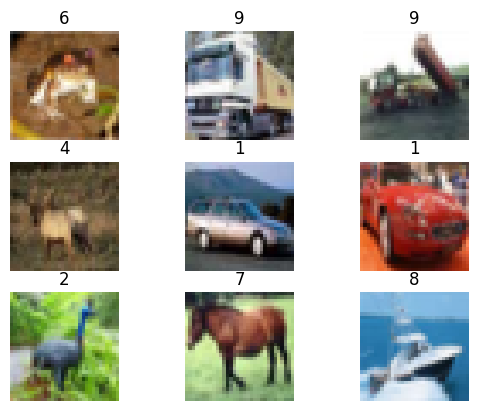

In [4]:
# Визуализация данных
nrows = 3
ncols = 3

for i in range(nrows * ncols):
    plt.subplot(nrows, ncols, i + 1)
    img, label = train_dataset[i]
    plt.imshow(img.moveaxis(0, 2))
    plt.title(label)
    plt.axis('off')
    plt.tick_params(left = False, right = False , labelleft = False , 
                    labelbottom = False, bottom = False)

plt.show()

In [18]:
# CNN Архитектура
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Сверточный слой
        self.conv_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=16,
                kernel_size=(2, 2),
                stride=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=1
            )
        )

        # Полносвязный слой
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 30 * 30, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # Прогон изображения через сверточный слой (Формирование карты признаков)
        x = self.conv_layer(x)

        # Прогон изображения с картой признаков через полносвязный слой
        logits = self.fc_layer(x)

        return logits
    

In [19]:
# Определение модели
model = CNN(10)

In [20]:
# Обучение модели
num_epochs = 10
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Функция потерь
criterion = nn.CrossEntropyLoss()
loss_list = []
acc_list = []

# Кол-во обучающих премеров
train_amount = len(train_dataloader)

# Загрузка модели на GPU
model.train().to(device)
# Обучение
for epoch in range(num_epochs):
    total_loss = 0
    total_acc = 0
    
    for data, targets in train_dataloader:
        # Обнуление градиентов
        optimizer.zero_grad()

        # Перевод всех данных на GPU
        data, targets = data.to(device), targets.to(device)

        # Предсказания модели
        outputs = model(data)

        # Расчет функции потерь
        loss = criterion(outputs, targets)

        # Прибавление функции потерь к общей потере за эпоху
        total_loss += loss.item()

        # Вычисление градиентов
        loss.backward()

        # Отпимизация весов на основе расчитанных градиентов
        optimizer.step()

        # Расчет точности (accuracy)
        total = targets.shape[0]
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == targets).sum().item()
        total_acc += correct / total
    
    # Расчет средней точности за эпоху
    avg_loss = total_loss / train_amount
    loss_list.append(avg_loss)

    # Расчет средней точности за эпоху
    avg_accuracy = total_acc / train_amount
    acc_list.append(avg_accuracy)

    # Вывод информации об эпохе обучения модели
    print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {avg_loss:.2f}, Accuracy: {avg_accuracy:.2f}')


Epoch: 1/10, Loss: 1.54, Accuracy: 0.44
Epoch: 2/10, Loss: 1.22, Accuracy: 0.56
Epoch: 3/10, Loss: 1.10, Accuracy: 0.61
Epoch: 4/10, Loss: 1.02, Accuracy: 0.64
Epoch: 5/10, Loss: 0.96, Accuracy: 0.66
Epoch: 6/10, Loss: 0.91, Accuracy: 0.68
Epoch: 7/10, Loss: 0.86, Accuracy: 0.70
Epoch: 8/10, Loss: 0.82, Accuracy: 0.71
Epoch: 9/10, Loss: 0.77, Accuracy: 0.73
Epoch: 10/10, Loss: 0.73, Accuracy: 0.74


In [23]:
# Оценка обученной модели
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for data, targets in test_dataloader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.shape[0]
        correct += (predicted == targets).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_dataloader), (correct / total) * 100))

Test Accuracy of the model on the 1000 test images: 60.38 %


### Экспериментировать с различными архитектурами:
Изменить количество слоев свертки, размер фильтров и параметры пулинга, чтобы понять, как изменения влияют на производительность и точность модели.
  
Задачи:
1. Добавить еще один сверточный слой с параметрами: P (Padding) = 0, K (Kernel Size) = (3, 3), S (Stride) = 1.
2. В первом сверточном слое изменить размеры фильтров на K = (5, 5).
3. В первом сверточном слое изменить измененить количество выходных каналов на out_channels = 32. Это позволит извлекать больше признаков из изображения.
4. Добавить Batch Normalization (Нормализация батча) после 1-го сверточного слоя для улучшения стабильности и ускорения обучения.
5. Изменить параметры 1-го MaxPool2D (пуллинга): S (Stride) с 1 на 2.
6. Добавить слой Dropout для регуляризации, чтобы уменьшить вероятность переобучения модели с вероятностью отключения нейрона p = 0.5.

In [40]:
class UpdatedCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        # Сверточный слой
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=32,
                kernel_size=(5, 5),
                stride=1
            ),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(
                kernel_size=(2, 2),
                stride=2
            )
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=(3, 3),
                stride=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(3, 3),
                stride=1
            )
        )

        # Полносвязный слой
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 10 * 10, 512),
            nn.ReLU(),
            nn.Dropout(0.15), # Регуляризация
            nn.Linear(512, n_classes)
        )
    
    def forward(self, x):
        # Прогон данных через сверточный слой 1
        x = self.conv_layer1(x)

        # Прогон данных через сверточный слой 2
        x = self.conv_layer2(x)

        # Прогон данных через полносвязный слой
        logits = self.fc_layer(x)

        return logits
    

In [41]:
# Определение модели, оптимизатора и функции потерь
model = UpdatedCNN(10)
n_classes = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [42]:
# Обучение модели
loss_list, acc_list = train_model(model, num_epochs, optimizer, criterion, train_dataloader)

Epoch: 1/10, Loss: 1.41, Accuracy: 0.50
Epoch: 2/10, Loss: 1.10, Accuracy: 0.62
Epoch: 3/10, Loss: 0.98, Accuracy: 0.66
Epoch: 4/10, Loss: 0.89, Accuracy: 0.69
Epoch: 5/10, Loss: 0.81, Accuracy: 0.72
Epoch: 6/10, Loss: 0.74, Accuracy: 0.74
Epoch: 7/10, Loss: 0.69, Accuracy: 0.76
Epoch: 8/10, Loss: 0.63, Accuracy: 0.78
Epoch: 9/10, Loss: 0.59, Accuracy: 0.79
Epoch: 10/10, Loss: 0.55, Accuracy: 0.81


In [43]:
# Оценка качества модели
eval_model(model, test_dataloader)

Test Accuracy of the model on the 1000 test images: 68.14 %


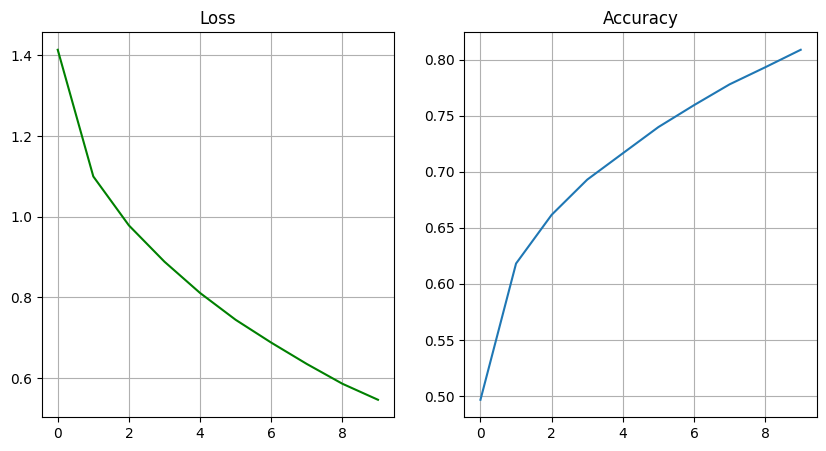

In [54]:
# Визуализация loss и accuracy
# 1-ый график
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_list, color='g')
plt.title("Loss")
plt.grid()

# 2-ой график
plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(acc_list)
plt.grid()

plt.show()

**Результат**: Качество модели выросло на ~8 %. Очень неплохой результат, модель стала обучаться быстрее, но при этом она не переобучается.